CUSTOMER BEHAVIOUR PREDICTION USING WEB USAGE MINING

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score


In [13]:
# Load dataset
df = pd.read_csv("C:/Users/Dell/OneDrive/Documents/project datasets/online_shoppers_intention.csv",encoding="utf-8")

print("Shape of dataset:", df.shape)
print("\nMissing values:\n", df.isnull().sum())
print("\nData types:\n", df.dtypes)


Shape of dataset: (12330, 18)

Missing values:
 Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

Data types:
 Administrative               int64
Administrative_Duration    float64
Informational                int64
Informational_Duration     float64
ProductRelated               int64
ProductRelated_Duration    float64
BounceRates                float64
ExitRates                  float64
PageValues                 float64
SpecialDay                 float64
Month                       object
OperatingSystems  

In [14]:
print(df.isnull().sum())

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64


In [15]:
# Copy dataset
data = df.copy()

# Encode Weekend & Revenue
data['Weekend'] = data['Weekend'].astype(int)
data['Revenue'] = data['Revenue'].astype(int)

# Encode VisitorType
le = LabelEncoder()
data['VisitorType'] = le.fit_transform(data['VisitorType'])

# One-hot encode Month
data = pd.get_dummies(data, columns=['Month'], drop_first=True)

# Split features & target
X = data.drop('Revenue', axis=1)
y = data['Revenue']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)


Train shape: (9864, 25) (9864,)
Test shape: (2466, 25) (2466,)


In [16]:
# Apply SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("Before SMOTE:\n", y_train.value_counts())
print("After SMOTE:\n", y_train_res.value_counts())


Before SMOTE:
 Revenue
0    8338
1    1526
Name: count, dtype: int64
After SMOTE:
 Revenue
0    8338
1    8338
Name: count, dtype: int64


In [17]:
# Smaller parameter space for speed
param_dist = {
    "n_estimators": [100, 200],
    "max_depth": [10, 20, None],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
    "bootstrap": [True]
}

rf = RandomForestClassifier(random_state=42)

# Fewer iterations & folds for speed
random_search = RandomizedSearchCV(
    rf, param_distributions=param_dist, 
    n_iter=5, cv=3, verbose=1, n_jobs=-1, random_state=42
)

# Fit on resampled (balanced) data
random_search.fit(X_train_res, y_train_res)

best_model = random_search.best_estimator_
print("Best parameters:", random_search.best_params_)


Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': None, 'bootstrap': True}


In [18]:
# Predictions
y_pred = best_model.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.8864557988645579

Confusion Matrix:
 [[1919  165]
 [ 115  267]]

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.92      0.93      2084
           1       0.62      0.70      0.66       382

    accuracy                           0.89      2466
   macro avg       0.78      0.81      0.79      2466
weighted avg       0.89      0.89      0.89      2466



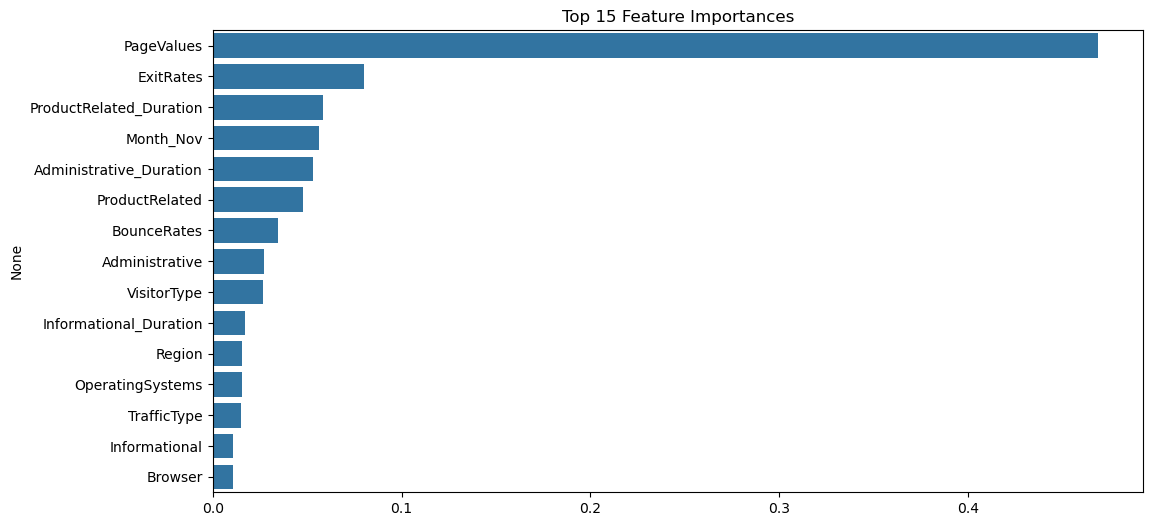

In [19]:
# Feature Importance
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12,6))
sns.barplot(x=importances[indices][:15], y=X.columns[indices][:15])
plt.title("Top 15 Feature Importances")
plt.show()


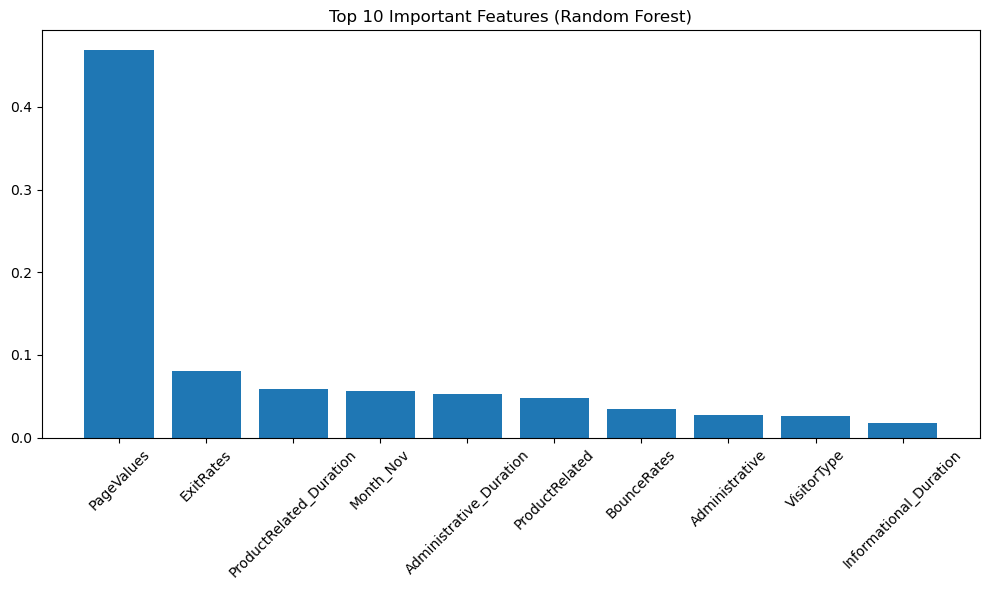

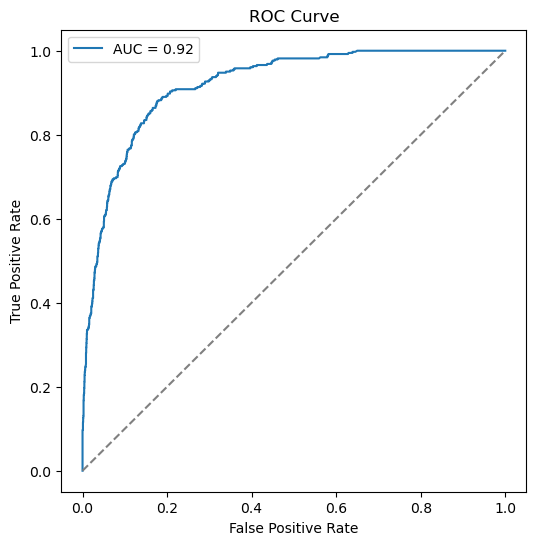

Cross-validation scores: [0.92011354 0.9107867  0.89983779 0.88280616 0.88037307]
Mean CV Accuracy: 0.8987834549878346

Sample Predictions (first 5 test rows):
[0 0 1 0 0]


In [20]:


# --- 1. Feature Importance ---
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns

plt.figure(figsize=(10,6))
plt.title("Top 10 Important Features (Random Forest)")
plt.bar(range(10), importances[indices[:10]], align="center")
plt.xticks(range(10), [features[i] for i in indices[:10]], rotation=45)
plt.tight_layout()
plt.show()

# --- 2. ROC-AUC Curve ---
y_pred_proba = best_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
from sklearn.metrics import auc as calc_auc
roc_auc = calc_auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# --- 3. Cross-validation scores ---
cv_scores = cross_val_score(best_model, X, y, cv=5, scoring="accuracy")
print("Cross-validation scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())

# --- 4. Example predictions ---
sample_inputs = X_test.iloc[:5]
sample_preds = best_model.predict(sample_inputs)
print("\nSample Predictions (first 5 test rows):")
print(sample_preds)


In [21]:
# Save best model
joblib.dump(best_model, "customer_behavior_model.pkl")
print("Model saved as customer_behavior_model.pkl")


Model saved as customer_behavior_model.pkl


In [22]:
# Load saved model
loaded_model = joblib.load("customer_behavior_model.pkl")

# Example: create a new customer data row
# (values must match the same preprocessing steps & feature order as training set)
sample_data = pd.DataFrame([{
    "Administrative": 2,
    "Administrative_Duration": 80.0,
    "Informational": 0,
    "Informational_Duration": 0.0,
    "ProductRelated": 20,
    "ProductRelated_Duration": 500.0,
    "BounceRates": 0.02,
    "ExitRates": 0.05,
    "PageValues": 20.0,
    "SpecialDay": 0.0,
    "OperatingSystems": 2,
    "Browser": 1,
    "Region": 3,
    "TrafficType": 2,
    "VisitorType": 1,   # 1 = Returning_Visitor (after LabelEncoder)
    "Weekend": 0,
    # Add dummy values for month dummies (must exist in your training columns)
    **{col: 0 for col in X.columns if col.startswith("Month_")}
}])

# Ensure columns match training
sample_data = sample_data.reindex(columns=X.columns, fill_value=0)

# Predict
prediction = loaded_model.predict(sample_data)[0]
print("Prediction:", "Purchase (Revenue=1)" if prediction == 1 else "No Purchase (Revenue=0)")


Prediction: Purchase (Revenue=1)
